In [1]:
%pip install textstat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import sent_tokenize
from textstat import flesch_reading_ease
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import requests
import time
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [4]:
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
print("Folders 'data' and 'models' are ready!")

Folders 'data' and 'models' are ready!


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91890\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
data_df = pd.read_csv('C:/Users/91890/Documents/mann_py/LeadWalnut/data/data.csv')

In [7]:
data_df = data_df.dropna(subset=['html_content']).reset_index(drop=True)
data_df['html_content'] = data_df['html_content'].astype(str)

In [8]:
def parse_html(html_content):
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        title = soup.title.string if soup.title else ''
        body_tags = soup.find_all(['p', 'article', 'main'])
        body_text = ' '.join([tag.get_text(strip=True) for tag in body_tags])
        body_text = re.sub(r'\s+', ' ', body_text).strip()  # Clean extra spaces
        word_count = len(body_text.split())
        return title, body_text, word_count
    except Exception as e:
        print(f"Error parsing HTML: {e}")
        return '', '', 0


extracted_data = []
for _, row in data_df.iterrows():
    title, body_text, word_count = parse_html(row['html_content'])
    extracted_data.append({
        'url': row['url'],
        'title': title,
        'body_text': body_text,
        'word_count': word_count
    })

extracted_df = pd.DataFrame(extracted_data)
extracted_df.to_csv('data/extracted_content.csv', index=False)
print("Extracted content saved to data/extracted_content.csv")

Extracted content saved to data/extracted_content.csv


In [9]:
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_sentence_count(text):
    return len(sent_tokenize(text))

def get_top_keywords(texts, vectorizer, n=5):
    tfidf_matrix = vectorizer.transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    top_keywords = []
    for doc in tfidf_matrix:
        indices = doc.toarray().argsort()[0][-n:]
        keywords = [feature_names[i] for i in indices]
        top_keywords.append('|'.join(keywords))
    return top_keywords


extracted_df = pd.read_csv('data/extracted_content.csv')

extracted_df['body_text'] = extracted_df['body_text'].fillna('')
extracted_df['body_text'] = extracted_df['body_text'].apply(clean_text)

extracted_df['sentence_count'] = extracted_df['body_text'].apply(get_sentence_count)
extracted_df['flesch_reading_ease'] = extracted_df['body_text'].apply(flesch_reading_ease)

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = vectorizer.fit_transform(extracted_df['body_text'])
extracted_df['top_keywords'] = get_top_keywords(extracted_df['body_text'], vectorizer)
extracted_df['embedding'] = [emb.toarray().flatten().tolist() for emb in tfidf_matrix]


joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')


features_df = extracted_df[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords', 'embedding']]
features_df.to_csv('data/features.csv', index=False)
print("Features saved to data/features.csv")

Features saved to data/features.csv


In [10]:
features_df = pd.read_csv('data/features.csv')
tfidf_matrix = np.array([eval(emb) for emb in features_df['embedding']])  # Convert back to array

sim_matrix = cosine_similarity(tfidf_matrix)


threshold = 0.80
duplicates = []
for i in range(len(sim_matrix)):
    for j in range(i+1, len(sim_matrix)):
        if sim_matrix[i][j] > threshold:
            duplicates.append({
                'url1': features_df['url'][i],
                'url2': features_df['url'][j],
                'similarity': sim_matrix[i][j]
            })

duplicates_df = pd.DataFrame(duplicates)
duplicates_df.to_csv('data/duplicates.csv', index=False)
print("Duplicates saved to data/duplicates.csv")

# Thin content detection
features_df['is_thin'] = features_df['word_count'] < 500

# Summary
total_pages = len(features_df)
duplicate_pairs = len(duplicates_df)
thin_pages = features_df['is_thin'].sum()
print(f"Total pages analyzed: {total_pages}")
print(f"Duplicate pairs: {duplicate_pairs}")
print(f"Thin content pages: {thin_pages} ({thin_pages/total_pages*100:.2f}%)")

Duplicates saved to data/duplicates.csv
Total pages analyzed: 69
Duplicate pairs: 2
Thin content pages: 18 (26.09%)


In [11]:
def assign_label(row):
    wc = row['word_count']
    re_score = row['flesch_reading_ease']
    if wc > 1500 and 50 <= re_score <= 70:
        return 'High'
    elif wc < 500 or re_score < 30:
        return 'Low'
    else:
        return 'Medium'

features_df['quality_label'] = features_df.apply(assign_label, axis=1)

# Features for model
X = features_df[['word_count', 'sentence_count', 'flesch_reading_ease']]
y = features_df['quality_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)


print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

def baseline_predict(wc):
    if wc > 1500:
        return 'High'
    elif wc < 500:
        return 'Low'
    else:
        return 'Medium'

y_baseline = X_test['word_count'].apply(baseline_predict)
print(f"Baseline Accuracy: {accuracy_score(y_test, y_baseline):.2f}")

# Top features
importances = clf.feature_importances_
top_features = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)[:3]
print("Top Features:")
for i, (feat, imp) in enumerate(top_features, 1):
    print(f"{i}. {feat} (importance: {imp:.2f})")


joblib.dump(clf, 'models/quality_model.pkl')
print("Model saved to models/quality_model.pkl")

Model Performance:
              precision    recall  f1-score   support

        High       1.00      0.50      0.67         2
         Low       0.93      1.00      0.96        13
      Medium       0.83      0.83      0.83         6

    accuracy                           0.90        21
   macro avg       0.92      0.78      0.82        21
weighted avg       0.91      0.90      0.90        21

Overall Accuracy: 0.90
Confusion Matrix:
[[ 1  0  1]
 [ 0 13  0]
 [ 0  1  5]]
Baseline Accuracy: 0.48
Top Features:
1. flesch_reading_ease (importance: 0.48)
2. word_count (importance: 0.28)
3. sentence_count (importance: 0.24)
Model saved to models/quality_model.pkl


In [18]:
def analyze_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        html_content = response.text
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return {}

    title, body_text, word_count = parse_html(html_content)
    body_text = clean_text(body_text)
    sentence_count = get_sentence_count(body_text)
    readability = flesch_reading_ease(body_text)

    vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
    embedding = vectorizer.transform([body_text]).toarray()[0]  # ← [0] fixes dim
    embedding = embedding.reshape(1, -1)

    clf = joblib.load('models/quality_model.pkl')
    features = pd.DataFrame([[word_count, sentence_count, readability]],
                            columns=['word_count', 'sentence_count', 'flesch_reading_ease'])
    quality_label = clf.predict(features)[0]
    is_thin = word_count < 500

    # Load existing embeddings (FIXED)
    features_df = pd.read_csv('data/features.csv')
    existing_embeddings = np.array([np.array(eval(emb)).flatten() for emb in features_df['embedding']])
    existing_embeddings = existing_embeddings.reshape(len(existing_embeddings), -1)

    sims = cosine_similarity(embedding, existing_embeddings)[0]
    similar_to = []
    for i, sim in enumerate(sims):
        if sim > 0.80:
            similar_to.append({'url': features_df['url'][i], 'similarity': float(sim)})

    return {
        'url': url,
        'word_count': word_count,
        'readability': readability,
        'quality_label': quality_label,
        'is_thin': is_thin,
        'similar_to': similar_to
    }

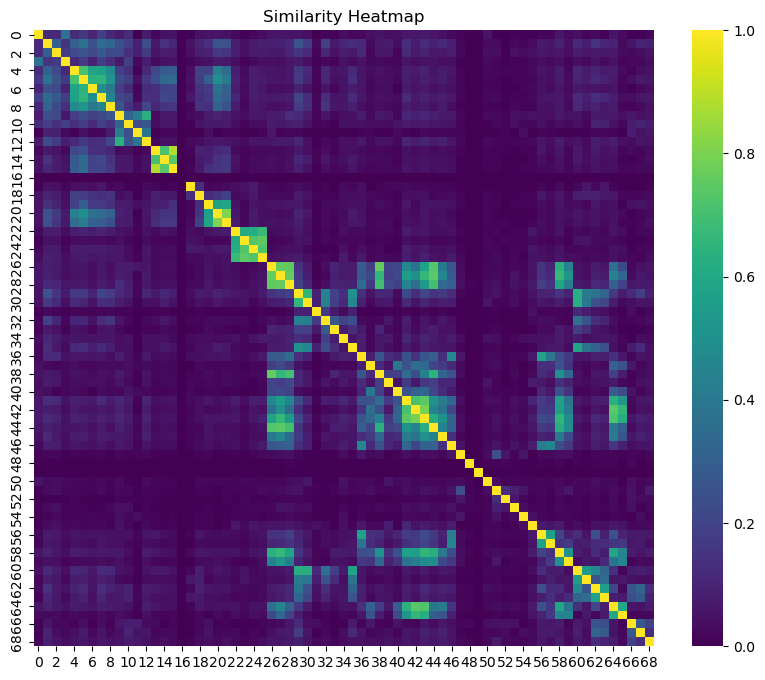

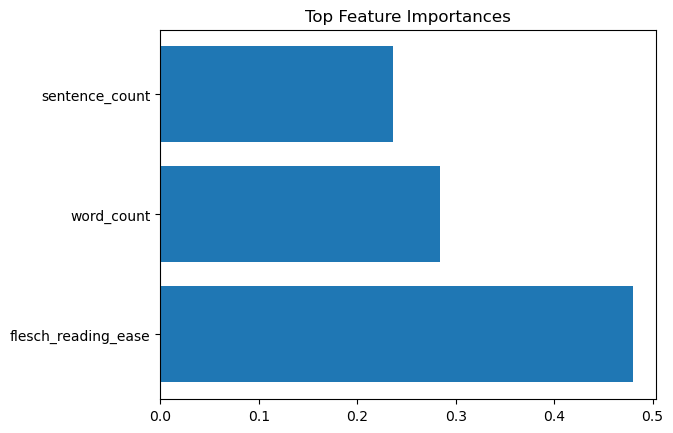

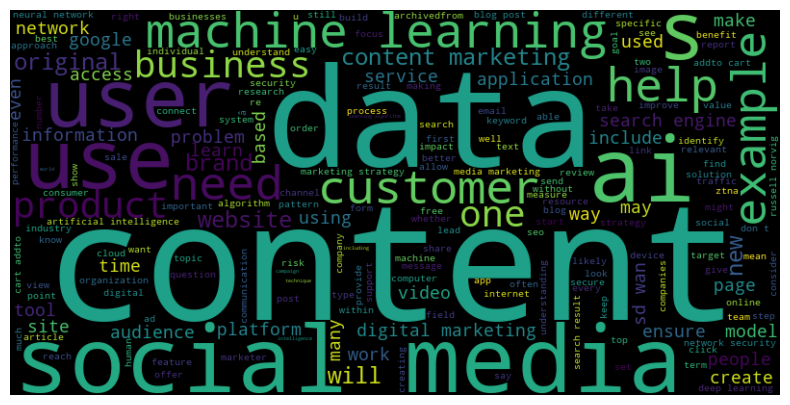

In [20]:
# Similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title('Similarity Heatmap')
plt.show()

# Feature importance plot
plt.barh([f[0] for f in top_features], [f[1] for f in top_features])
plt.title('Top Feature Importances')
plt.show()

# Word cloud

all_text = ' '.join(extracted_df['body_text'])
wordcloud = WordCloud(width=800, height=400).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
url= input("Enter your URL for analysis:")

In [22]:
result = analyze_url(url)
print(json.dumps(result, indent=2))

{
  "url": "https://jserd.springeropen.com/articles/10.1186/s40411-018-0060-6",
  "word_count": 28042,
  "readability": 36.504254664650404,
  "quality_label": "Medium",
  "is_thin": false,
  "similar_to": []
}
